# Image classification using deeplearning 

For this challenge, I chose to work on the problem of image classification. Image classification is a supervised learning approach that aims training a model using labled examples (called training set) and use it to predict the label for new examples (called test set). It is composed of feature extraction and classifier training stages. The featrue extraction step aims to generate a new representation for a given image. The classifier aims to learn the decision boundary between different classes. Early classification approaches used hand crafted feature extraction techniques such as Histogram of gradients (HOG) and Scale invariant feature transform (SIFT) to convert an image from the pixel space to the new space. Then, a classifier is trained in this new space to get the decision boundary between different classes.

The availability of large real world datasets and high performance computational devices have enabled researchers to develop end-to-end approaches for image classification. These approaches train deep neural network models (neural network models made up of several layers) to automatically learn image features and decision boundaries from the data itself. Compared to hand crafted features, automatically learned features have significantly improved state of the art classification performance on several datasets.

In this report, I train deep learning models to classify food images into one of the 101 categories. 

I will describe the dataset followed by the discussion of the models I chose to work with. Finally, I present performance values obtained by the models on the test set images.

## Dataset
Food-101 is a collection of food images acquired by users. It is composed of 101 food categories (classes). Each class has 750 training images and 250 test images. All images are resized to have a maximum side length of 512 pixels. For the purpose of this work, I used $20\%$ of the training samples as a validation set. Accordingly, the training set has 600 images per-class and the validation and test sets have 150 and 250 samples per-class, respectively. Some examples of the images are shown bellow.


In [1]:
# Import libraries
from __future__ import absolute_import, division, print_function, unicode_literals
import datetime as dt
from itertools import chain
import glob
import json
import os
import random

import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image 
import tensorflow as tf 
from tensorflow import keras as K
import tensorflow.keras.layers as L
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2


In [2]:
# Define some global variables
IMAGE_DIR = '../food-101/dataset/images' # path to images
META_PATH = '../food-101/dataset/meta' # path to meta files
HEIGHT = 256 #Image height
WIDTH = 256 #Image width
BATCH = 64 #Batch size
CHANNEL = 3 #Number of channels in the input
NUM_FILTER = 64 #number of filters for the first convolution layer
KERNEL = 3 #convolution kernel size
NUM_CLASSES = 101 #Number of classes
EPOCHS = 50
L2_LAMBDA = 1e-4 # regularizer lambda value
NUM_FEATURES = 4096 #Number of features
WEIGHT_DECAY = 1e-4

In [3]:
def trainValSplit(path_to_json):
    """
    Read training json file and split the images into
    training and validation set.abs
    Args:
        path_to_json--> path to the train.json file
    Return:
        write training and validation json files. 
    """
    with open(path_to_json, 'r+') as fp:
        data = json.load(fp)
    train, val = {}, {}
    #from each class take the first 150 samples for validation
    #and the rest for training. 

    for k, v in data.items():
        num_val = int(0.2*len(v))
        train[k] = v[num_val:]
        val[k] = v[:num_val]
    # write to json files
    with open('./dataset/meta/train_new.json', 'w+') as fp:
        json.dump(train, fp)
    with open('./dataset/meta/val.json', 'w+') as fp:
        json.dump(val, fp)
    for k, v in train.items():
        print(k, len(v))
    for k, v in val.items():
        print(k, len(v))

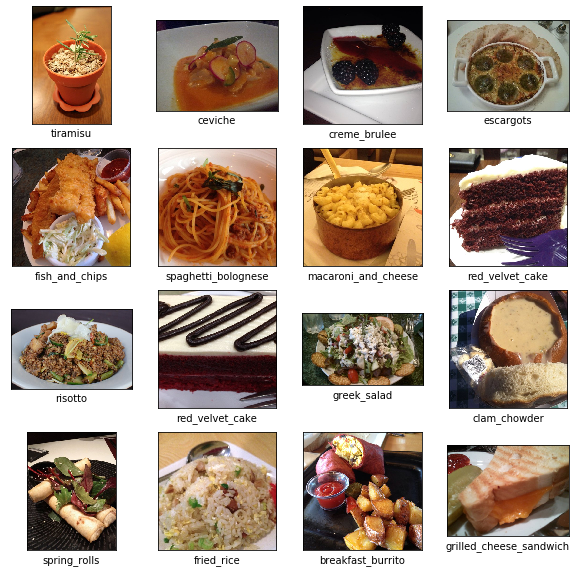

In [4]:
def plotSamples():
    """
    Visualize sample images from the dataset
    """
    image_list = glob.glob(IMAGE_DIR + '/*/*.jpg')
    # randomly select 16 images
    index = np.random.randint(0, len(image_list), size=(16,))   
    plt.figure(figsize=(10,10))
    for i, j in enumerate(index):
        image = Image.open(image_list[j])
        #parse image label from the file name
        label = image_list[j].split('/')[-2]
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(label)
    plt.show()

plotSamples()

## Preprocessing
The first step in the preprocessing stage is to resize the images into the appropriate shape used by the model.
Each image is resized as follows:
* For each image get pixels size of the smallest side 
* In the case of training images
    * Randomly crop a square patch with the size of the smallest side (For example: if the image is size of $480\times640$ patch size will be $480\times480$)
* In the case of validation and test sets 
    * Remove the edges from the longest side.
* Resize the new patch to the desired size 

The second step is scaling pixel values in the range of $[0-1]$ and apply data augmentation operations on the training set images.
In all the experiments, I applied two types of augmentations: randomly flipping an image from left to right and randomly adjusting the brightness of the images.
I added the second augmentation method to take into account the fact that images are acquired in different lighting conditions in real scenario.



In [5]:
def readJson(path, shuffle=True):
    """
    Read JSON file.
    Args:
        path--> path to the file
        shuffle--> If True randomly shuffle the data
    Return:
        name_list--> a list with the file names
    """
    with open(path, 'r+') as fp:
        data = json.load(fp)
    name_list = list(chain(*data.values()))
    if shuffle:
        random.shuffle(name_list)
    return name_list

def getDataset(image_dir, meta_file_path, extension):
    """
    Read JSON files containing dataset file names and return
    a dictionary containing the path each image and corresponding label.
    Args:
        image_dir--> path where the images are saved
        meta_file_path--> path to the JSON and text files
        extension--> image file type (eg '.jpg')
    Return:
        dataset--> a dictionary with training, validation, and test images
                   and corresponding labels
    """
    #Get class names and map them to numeric label
    with open('{}/classes.txt'.format(META_PATH), 'r+') as fp:
        classes = fp.readlines()
    label_map = {name.strip('\n'): i for i, name in enumerate(classes)}

    dataset = dict()

    #Read JSON files 
    train_file_name = readJson(META_PATH + '/train_new.json')
    val_file_name = readJson(META_PATH + '/val.json', shuffle=False)
    test_file_name = readJson(META_PATH + '/test.json', shuffle=False)

    #Get path to the images
    train_images = np.array([os.path.join(IMAGE_DIR, f.strip('\n') + extension) for f in train_file_name])
    val_images = np.array([os.path.join(IMAGE_DIR, f.strip('\n') + extension) for f in val_file_name])
    test_images = np.array([os.path.join(IMAGE_DIR, f.strip('\n') + extension) for f in test_file_name])
    
    #Map image name to the corresponding numeric label
    train_labels = np.array([label_map[f.split('/')[-2]] for f in train_images])
    val_labels = np.array([label_map[f.split('/')[-2]] for f in val_images])
    test_labels = np.array([label_map[f.split('/')[-2]] for f in test_images])

    #Ensure the numeber of images and labels is the same
    assert len(train_images)==len(train_labels)
    assert len(val_images)==len(val_labels)
    assert len(test_images)==len(test_labels)

    #Add the lists to the dictionary    
    dataset['train_x'] = tf.convert_to_tensor(train_images, dtype=tf.string)
    dataset['train_y'] = tf.convert_to_tensor(train_labels, dtype=tf.uint8)
    dataset['val_x'] = tf.convert_to_tensor(val_images, dtype=tf.string)
    dataset['val_y'] = tf.convert_to_tensor(val_labels, dtype=tf.uint8)
    dataset['test_x'] = tf.convert_to_tensor(test_images, dtype=tf.string)
    dataset['test_y'] = tf.convert_to_tensor(test_labels, dtype=tf.uint8)

    return dataset   

In [6]:
def readImage(image_dir, label, train=False):
    """
    Read an image from the directory and return a tuple of image tensor and 
    corresponding label.
    Args: 
        image_dir--> path (tensor) to the file/image.
        label --> image label
        train --> if the image is from training set or not
    Returns:
        image--> Image resized to the model requirement
        label--> class of the image   
    """
    #Read image
    image = tf.io.read_file(image_dir)
    image = tf.image.decode_image(image, channels=3)
    image_shape = tf.shape(image)
    
    #Get the size of the smallest side
    crop_size = tf.minimum(image_shape[0], image_shape[1])
    
    if train:
        image = tf.image.random_crop(image, size=(crop_size, crop_size, image_shape[-1]))
    else:
        #Remove edges in case of validation or test set images
        if image_shape[0] >= image_shape[1]:
            diff = (image_shape[0] - image_shape[1])//2
            offset_height, offset_width = diff, 0
        else:
            diff = (image_shape[1] - image_shape[0])//2
            offset_height, offset_width = 0, diff
        image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, crop_size, crop_size)
    
    #Resize the image
    image = tf.image.resize(image, (HEIGHT, WIDTH), 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)                              
    
    return image, label

def preProcessBatch(batch_image, batch_label, train=False):
    """
    Apply augmentation and standardization operations.
    Args:
        batch_image--> 4D array of images ([BATCH, HEIGHT, WIDTH, CHANNEL])
        batch_label--> label corresponding to the images ([BATCH])
    Return:
        batch_image--> 4D array of images after transformation
        batch_label--> One hot encoding of the labels
    """

    if train:
        batch_image = tf.image.random_flip_left_right(batch_image)
        batch_image = tf.image.random_brightness(batch_image, 0.2)
    
    batch_image = tf.image.convert_image_dtype(batch_image, dtype=tf.float32)
    batch_label = tf.one_hot(batch_label, depth=NUM_CLASSES, dtype=tf.float32)
    batch_image = tf.image.per_image_standardization(batch_image)

    assert batch_image.shape[0]==batch_label.shape[0]
    assert batch_label.shape[1]==NUM_CLASSES

    return batch_image, batch_label

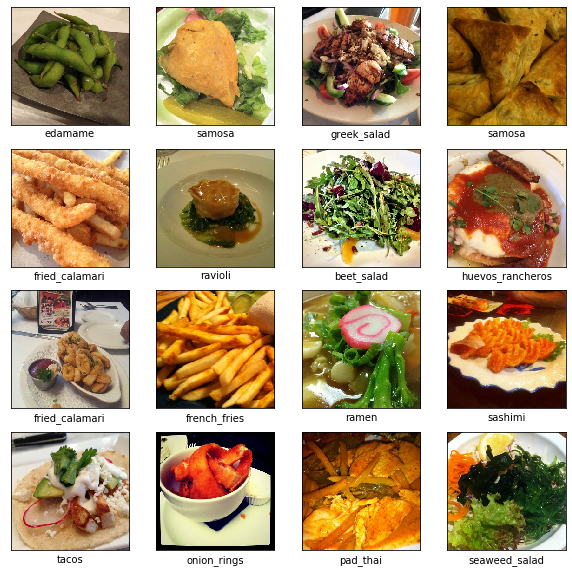

In [7]:
#visualize training images after transformation
def plotTrainSamples():
    #Plot training samples
    dataset = getDataset(IMAGE_DIR, META_PATH, '.jpg')
    #read class names
    with open('{}/classes.txt'.format(META_PATH), 'r+') as fp:
        classes = fp.readlines()
    train = tf.data.Dataset.from_tensor_slices((dataset['train_x'], dataset['train_y']))
    train = train.map(lambda x, y: readImage(x, y, train=True))
    plt.figure(figsize=(10,10))
    for i, data in enumerate(train.take(16)):
        image = data[0].numpy()
        label = classes[data[1]]
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(label)
    plt.show()

plotTrainSamples()

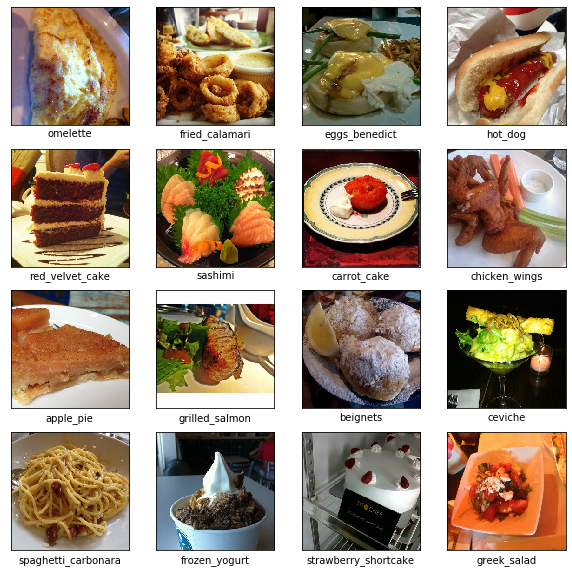

In [8]:
#visualize test images after transformation
def plotTestSamples():
    #plot test samples
    dataset = getDataset(IMAGE_DIR, META_PATH, map_classes, '.jpg')
    #read class names
    with open('{}/classes.txt'.format(META_PATH), 'r+') as fp:
        classes = fp.readlines()
    test = tf.data.Dataset.from_tensor_slices((dataset['test_x'], dataset['test_y']))
    test = train.map(lambda x, y: readImage(x, y, train=False))
    plt.figure(figsize=(10,10))
    for i, data in enumerate(plotTestSamples.take(16)):
        image = data[0].numpy()
        label = classes[data[1]]
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(label)
    plt.show()

plotTrainSamples()

# Classification model
For this task, I considered two approaches. The first is training a deeplearning model from scratch and the second is to fine tune a pre-trained model for this task.
## Training deeplearning model from scratch
In this approach, I implemented a smaller version of the [HRNET](https://arxiv.org/pdf/1904.04514.pdf) (High-Resolution Representations for Labeling Pixels and Regions) architecture. This network has multiple
parallel structures that maintain high resolution representations. Compared to existing methods that connect subnetworks in series from low to high resolution or vice versa, this
model maintains high resolution representations and performs multi-scale fusion of features throughout the process. The authors have shown efficacy of the model on tasks such as pose 
estimation, semantic segmentation and object classification problems. 

I followed similar setup suggested by the authors but due to computational resource limitation, I implemented a lighter version of the model. First, the input passes through two convolution blocs reducing spatial size of the feature map to $\frac{1}{4}$ of the input. This is followed by the HRNET architecture shown bellow.

![](./hrnet.png)

The output is a fully connected layer with 101 neurons (which is equal to the number of classes) and the cross-entropy loss is used to compute the error between the predicted labels and the ground truth

$L = \sum _{c=1}^C y\log{\hat{y}}$

where $C$ is the number of classes, $y$ is ground truth label, and $\hat{y}$ is the predicted label.


 

### Create the model

In [ ]:
#HRNET model
class HRNET:

    def __init__(self, log_dir):
        self.log_dir = log_dir
    
    def resNetBlock(self, inputs, filters, kernel_size=3, stride=1, name='resblock'):
        """
        ResNet block 
        Args:
            inputs--> 4D Input feature map
            filters--> Number of filters (int)
            kernel_size--> kernel size (int)
            stride --> stride (int)
            name --> sub network name (string)
        Retruns:
            x--> 4D array of spatial size the same as the input and number of channels
                equal to filters 
        """
        input_shape = inputs.shape
        #Fisrt conv layer
        x = L.Conv2D(filters, kernel_size=kernel_size, 
            strides=stride, padding='same', use_bias=False, name='{}-conv-1'.format(name),
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(inputs)
        x = L.BatchNormalization(name='{}-bn-1'.format(name))(x)
        x = L.ReLU(name='{}-relu-1'.format(name))(x)
        # Second conv layer
        x = L.Conv2D(filters,kernel_size=kernel_size, 
            strides=1, padding='same', use_bias=False, name='{}-conv-2'.format(name),
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(x)
        x = L.BatchNormalization(name='{}-bn-21'.format(name))(x)
        #Add short cut
        if input_shape[-1]!= x.shape[-1]:
            _inputs = L.Conv2D(x.shape[-1], kernel_size=1, 
                    strides=stride, padding='same', use_bias=False, name='{}-conv-1x1'.format(name),
                    kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(inputs)
            _inputs = L.BatchNormalization()(_inputs)
            x = L.Add(name='{}-add'.format(name))([x, _inputs])
        else:
            x = L.Add(name='{}-add'.format(name))([x, inputs])
        x = L.ReLU(name='{}-relu-2'.format(name))(x)
        
        return x


    def network(self, x):
        """
        Create the HRNET architecture
        """
        #First convolution layer
        x = L.Conv2D(filters=NUM_FILTER, kernel_size=KERNEL, strides=2, padding='same', 
            use_bias=False, name='conv-1',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(x)
        x = L.BatchNormalization(name='conv-1-bn')(x)
        x = L.ReLU(name='conv-1-relu')(x)
        # second convolution layer
        x = L.Conv2D(filters=2*NUM_FILTER, kernel_size=KERNEL, strides=2, padding='same', 
            use_bias=False, name='conv-2',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(x)
        x = L.BatchNormalization(name='conv-2-bn')(x)
        x = L.ReLU(name='conv-2-relu')(x)
        print('Initial layer output: {}'.format(x.shape))
        #Stage 1 residual and blocks
        stage_one_x = self.resNetBlock(x, filters=NUM_FILTER, name='stage-1-res-1')

        stage_one_conv = L.Conv2D(filters=NUM_FILTER//2, kernel_size=KERNEL, padding='same', 
            use_bias=False, name='stage-1-conv-1', kernel_initializer='glorot_normal', 
            kernel_regularizer=l2(WEIGHT_DECAY))(stage_one_x)
        stage_one_conv = L.BatchNormalization(name='stage-1-conv-1-bn')(stage_one_conv)
        stage_one_conv = L.ReLU(name='stage-1-conv-1-relu')(stage_one_conv)
        start_width_C = stage_one_conv.shape[-1]

        stage_two_conv = L.Conv2D(filters=2*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-2-conv-1', kernel_initializer='glorot_normal', 
            kernel_regularizer=l2(WEIGHT_DECAY))(stage_one_x)
        stage_two_conv = L.BatchNormalization(name='stage-2-conv-1-bn')(stage_two_conv)
        stage_two_conv = L.ReLU(name='stage-2-conv-1-relu')(stage_two_conv)

        stage_one_x = self.resNetBlock(stage_one_conv, filters=start_width_C, name='stage-1-res_2')
        
        # Stage two residual blocks
        stage_two_x = self.resNetBlock(stage_two_conv, filters=2*start_width_C, name='stage-2-res-1')
        

        stage_two_upsample = L.UpSampling2D()(stage_two_x)
        stage_two_upsample_conv = L.Conv2D(filters=start_width_C, kernel_size=KERNEL, 
            padding='same', use_bias=False, name='stage-two-upsample-conv-1',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_two_upsample)
        stage_two_upsample_conv = L.BatchNormalization(name='stage-two-upsample-conv-1-bn')(stage_two_upsample_conv)
        stage_two_upsample_conv = L.ReLU(name='stage-two-upsample-conv-1-relu')(stage_two_upsample_conv)

        stage_one_conv = L.Conv2D(filters=start_width_C, kernel_size=KERNEL, padding='same', 
            use_bias=False, name='stage-1-conv-2', kernel_initializer='glorot_normal',
            kernel_regularizer=l2(WEIGHT_DECAY))(stage_one_x)
        stage_one_conv = L.BatchNormalization(name='stage-1-conv-2-bn')(stage_one_conv)
        stage_one_conv = L.ReLU(name='stage-1-conv-2-relu')(stage_one_conv)
        
        
        stage_one_downsample = L.Conv2D(filters=2*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-1-downsample-conv-1',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_one_x)
        stage_one_downsample = L.BatchNormalization(name='stage-1-downsample-conv-1-bn')(stage_one_downsample)
        stage_one_downsample = L.ReLU(name='stage-1-downsample-conv-1-relu')(stage_one_downsample)

        stage_two_conv = L.Conv2D(filters=2*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-2-conv-2',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_one_x)
        stage_two_conv = L.BatchNormalization(name='stage-2-conv-2-bn')(stage_two_conv)
        stage_two_conv = L.ReLU(name='stage-2-conv-2-relu')(stage_two_conv)

        stage_three_conv_one = L.Conv2D(filters=4*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-three-conv-one',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_two_x)
        stage_three_conv = L.BatchNormalization(name='stage-three-conv-one-bn')(stage_three_conv_one)
        stage_three_conv = L.ReLU(name='stage-three-conv-one-relu')(stage_three_conv_one)

        stage_three_conv_two = L.Conv2D(filters=4*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-three-conv-two',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_one_downsample)
        stage_three_conv = L.BatchNormalization(name='stage-three-conv-two-bn')(stage_three_conv_two)
        stage_three_conv = L.ReLU(name='stage-three-conv-two-relu')(stage_three_conv_two)

        stage_one_x = L.Add()([stage_one_conv, stage_two_upsample_conv])
        stage_two_x = L.Add()([stage_one_downsample, stage_two_conv])
        stage_three_x = L.Add()([stage_three_conv_one, stage_three_conv_two])

        stage_one_x = self.resNetBlock(stage_one_x, filters=start_width_C, name='stage-1-res-3')
        stage_two_x = self.resNetBlock(stage_two_x, filters=2*start_width_C, name='stage-2-res-2')
        stage_three_x = self.resNetBlock(stage_three_x, filters=4*start_width_C, name='stage-3-res-1')

        #Add a fourth group
        #Input to the first resolution
        stage_two_upsample = L.UpSampling2D()(stage_two_x)
        stage_two_upsample_conv = L.Conv2D(filters=start_width_C, kernel_size=KERNEL, 
            padding='same', use_bias=False, name='stage-two-upsample-conv-2',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_two_upsample)
        stage_two_upsample_conv = L.BatchNormalization(name='stage-two-upsample-conv-2-bn')(stage_two_upsample_conv)
        stage_two_upsample_conv = L.ReLU(name='stage-two-upsample-conv-2-relu')(stage_two_upsample_conv)

        stage_three_upsample_0 = L.UpSampling2D(size=(4, 4))(stage_three_x)
        stage_three_upsample_conv_0 = L.Conv2D(filters=start_width_C, kernel_size=KERNEL, 
            padding='same', use_bias=False, name='stage_three_upsample-conv-1',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_three_upsample_0)
        stage_three_upsample_conv_0 = L.BatchNormalization(name='stage_three_upsample-conv-1-bn')(stage_three_upsample_conv_0)
        stage_three_upsample_conv_0 = L.ReLU(name='stage_three_upsample-conv-1-relu')(stage_three_upsample_conv_0)

        stage_one_conv = L.Conv2D(filters=start_width_C, kernel_size=KERNEL, padding='same', 
            use_bias=False, name='stage-1-conv-3', kernel_initializer='glorot_normal',
            kernel_regularizer=l2(WEIGHT_DECAY))(stage_one_x)
        stage_one_conv = L.BatchNormalization(name='stage-1-conv-3-bn')(stage_one_conv)
        stage_one_conv = L.ReLU(name='stage-1-conv-3-relu')(stage_one_conv)

        stage_one_x_input = L.Add()([stage_one_conv, stage_two_upsample_conv, stage_three_upsample_conv_0])

        #Input to the second resolution
        stage_three_upsample_1 = L.UpSampling2D()(stage_three_x)
        stage_three_upsample_conv_1 = L.Conv2D(filters=2*start_width_C, kernel_size=KERNEL, 
            padding='same', use_bias=False, name='stage_three_upsample-conv-2',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_three_upsample_1)
        stage_three_upsample_conv_1 = L.BatchNormalization(name='stage_three_upsample-conv-2-bn')(stage_three_upsample_conv_1)
        stage_three_upsample_conv_1 = L.ReLU(name='stage_three_upsample-conv-2-relu')(stage_three_upsample_conv_1)

        stage_one_downsample_0 = L.Conv2D(filters=2*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-1-downsample-conv-2',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_one_x)
        stage_one_downsample_0 = L.BatchNormalization(name='stage-1-downsample-conv-2-bn')(stage_one_downsample_0)
        stage_one_downsample_0 = L.ReLU(name='stage-1-downsample-conv-2-relu')(stage_one_downsample_0) 

        stage_two_conv = L.Conv2D(filters=2*start_width_C, kernel_size=KERNEL, 
            padding='same', use_bias=False, name='stage-2-conv-3',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_two_x)
        stage_two_conv = L.BatchNormalization(name='stage-2-conv-3-bn')(stage_two_conv)
        stage_two_conv = L.ReLU(name='stage-2-conv-3-relu')(stage_two_conv)

        stage_two_x_input = L.Add()([stage_one_downsample_0, stage_two_conv, stage_three_upsample_conv_1])

        #Input to the third resolution
        stage_three_conv = L.Conv2D(filters=4*start_width_C, kernel_size=KERNEL, 
            padding='same', use_bias=False, name='stage-3-conv-1',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_three_x)
        stage_three_conv = L.BatchNormalization(name='stage-3-conv-1-bn')(stage_three_conv)
        stage_three_conv = L.ReLU(name='stage-3-conv-1-relu')(stage_three_conv)

        stage_one_downsample_1 = L.Conv2D(filters=4*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-1-downsample-conv-3',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_one_downsample_0)
        stage_one_downsample_1 = L.BatchNormalization(name='stage-1-downsample-conv-3-bn')(stage_one_downsample_1)
        stage_one_downsample_1 = L.ReLU(name='stage-1-downsample-conv-3-relu')(stage_one_downsample_1)

        stage_two_downsample_0 = L.Conv2D(filters=4*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-2-downsample-conv-1',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_two_x)
        stage_two_downsample_0 = L.BatchNormalization(name='stage-2-downsample-conv-1-bn')(stage_two_downsample_0)
        stage_two_downsample_0 = L.ReLU(name='stage-2-downsample-conv-1-relu')(stage_two_downsample_0)

        stage_three_x_input = L.Add()([stage_one_downsample_1, stage_two_downsample_0, stage_three_conv])

        #Input to the fourth stage
        stage_one_downsample_2 = L.Conv2D(filters=8*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-1-downsample-conv-4',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_one_downsample_1)
        stage_one_downsample_2 = L.BatchNormalization(name='stage-1-downsample-conv-4-bn')(stage_one_downsample_2)
        stage_one_downsample_2 = L.ReLU(name='stage-1-downsample-conv-4-relu')(stage_one_downsample_2) 

        stage_two_downsample_1 = L.Conv2D(filters=8*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-2-downsample-conv-2',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_two_downsample_0)
        stage_two_downsample_1 = L.BatchNormalization(name='stage-2-downsample-conv-2-bn')(stage_two_downsample_1)
        stage_two_downsample_1 = L.ReLU(name='stage-2-downsample-conv-2-relu')(stage_two_downsample_1) 

        stage_three_downsample_0 = L.Conv2D(filters=8*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-three-downsample-conv-1',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_three_x)
        stage_three_downsample_0 = L.BatchNormalization(name='stage-three-downsample-conv-1-bn')(stage_three_downsample_0)
        stage_three_downsample_0 = L.ReLU(name='stage-three-downsample-conv-1-relu')(stage_three_downsample_0)

        stage_four_x_input = L.Add()([stage_one_downsample_2, stage_two_downsample_1, stage_three_downsample_0])  

        stage_one_x = self.resNetBlock(stage_one_x_input, filters=start_width_C, name='stage-1-res-4')
        stage_two_x = self.resNetBlock(stage_two_x_input, filters=2*start_width_C, name='stage-2-res-3')
        stage_three_x = self.resNetBlock(stage_three_x_input, filters=4*start_width_C, name='stage-3-res-2')
        stage_four_x = self.resNetBlock(stage_four_x_input, filters=8*start_width_C, name='stage-4-res-1')          


        print('Final shape of stage 1: {}'.format(stage_one_x.shape))
        print('Final shape of stage 2: {}'.format(stage_two_x.shape))
        print('Final shape of stage 3: {}'.format(stage_three_x.shape))
        print('Final shape of stage 4: {}'.format(stage_four_x.shape))

        stage_one_downsample = L.Conv2D(filters=2*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-1-downsample-conv-5',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_one_x)
        stage_one_downsample = L.BatchNormalization(name='stage-1-downsample-conv-5-bn')(stage_one_downsample)
        stage_one_downsample = L.ReLU(name='stage-1-downsample-conv-5-relu')(stage_one_downsample)

        stage_two_x =  L.Add()([stage_one_downsample, stage_two_x])

        stage_two_downsample = L.Conv2D(filters=4*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-two-downsample-conv-3',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_two_x)
        stage_two_downsample = L.BatchNormalization(name='stage-two-downsample-conv-3-bn')(stage_two_downsample)
        stage_two_downsample = L.ReLU(name='stage-two-downsample-conv-3-relu')(stage_two_downsample)

        stage_three_x =  L.Add()([stage_two_downsample, stage_three_x])

        stage_three_downsample = L.Conv2D(filters=8*start_width_C, kernel_size=KERNEL, strides=2, 
            padding='same', use_bias=False, name='stage-three-downsample-conv-2',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_three_x)
        stage_three_downsample = L.BatchNormalization(name='stage-three-downsample-conv-2-bn')(stage_three_downsample)
        stage_two_downsample = L.ReLU(name='stage-three-downsample-conv-2-relu')(stage_three_downsample) 

        stage_four_x =  L.Add()([stage_three_downsample, stage_four_x])     

        final_conv = L.Conv2D(filters=NUM_FEATURES, kernel_size=1, padding='same', name='final-conv',
            kernel_initializer='glorot_normal', kernel_regularizer=l2(WEIGHT_DECAY))(stage_four_x)
        final_conv = L.BatchNormalization(name='final-conv-bn')(final_conv)
        final_conv = L.ReLU(name='final-conv-relu')(final_conv)
        #apply global average pooling
        out_features = L.GlobalAveragePooling2D()(final_conv)
        out_features = L.Flatten()(out_features)
        print('Output feature map: {}'.format(out_features.shape))
        logits = L.Dense(NUM_CLASSES, kernel_initializer='glorot_normal', 
            kernel_regularizer=l2(WEIGHT_DECAY))(out_features)
        print('Output classes: {}'.format(logits.shape))
        return logits

    def train(self, restore_dir=None):
        """
        Creates the HRNET network, read training data, train  and evaluate the performance on test samples 
        """

        def scheduler(epoch):
            #reduce the learning rate by 0.1 every 25 epochs
            return 0.01*np.power(10, -(np.floor(epoch/10)))  
        #Reset graph
        tf.keras.backend.clear_session()
        
        # Read images
        dataset = getDataset(IMAGE_DIR, META_PATH, '.jpg')

        #Create training, validation, and test dataset using tf.data
        train = tf.data.Dataset.from_tensor_slices((dataset['train_x'], dataset['train_y']))
        train = train.shuffle(1000, reshuffle_each_iteration=True)
        train = train.map(lambda x, y: readImage(x, y, train=True))
        train = train.batch(BATCH, drop_remainder=True)
        train = train.map(lambda x, y: preProcessBatch(x, y, train=True))

        validation = tf.data.Dataset.from_tensor_slices((dataset['val_x'], dataset['val_y']))
        validation = validation.map(lambda x, y: readImage(x, y, train=False))
        validation = validation.batch(BATCH)
        validation = validation.map(lambda x, y: preProcessBatch(x, y, train=False))

        test = tf.data.Dataset.from_tensor_slices((dataset['test_x'], dataset['test_y']))
        test = test.map(lambda x, y: readImage(x, y, train=False))
        test = test.batch(BATCH)
        test = test.map(lambda x, y: preProcessBatch(x, y, train=False))

        #Check point and model save directory
        checkpoint_dir = self.log_dir + \
            '/checkpoint_{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))

        #Check is the directory exits and create if not
        if not os.path.isdir(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        model_weight = self.log_dir + \
            '/food-101-hrnet-{}.h5'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        #Model input
        x = K.Input(shape=(HEIGHT, WIDTH, CHANNEL))
        logits = self.network(x) #create the model
        model = K.Model(inputs=x, outputs=logits, name='food_101_hrnet')
        model.summary() #Display model summary
        model_plot = './hrnet-mod-{}.png'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        #save model in png file
        K.utils.plot_model(model, model_plot, show_shapes=True)
        optimizer = K.optimizers.SGD(learning_rate=0.01, momentum=0.9)
        #Load weights from a file. Used to resume training.
        if restore_dir is not None:
            model.load_weights(restore_dir)
        #Compile the model
        model.compile(optimizer=optimizer, 
            loss=K.losses.CategoricalCrossentropy(from_logits=True), metrics=['categorical_accuracy'])
        model_path = checkpoint_dir + "/weights-{epoch:02d}-{val_loss:.2f}.hdf5"

        #Define callbacks
        callbacks = [K.callbacks.TensorBoard(checkpoint_dir, write_images=True),
            K.callbacks.ModelCheckpoint(model_path, save_weights_only=True, save_best_only=True),
            tf.keras.callbacks.EarlyStopping(min_delta=1e-4, patience=10, restore_best_weights=True, verbose=1),
            tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)]
        #Train the model
        history = model.fit(x=train, epochs=EPOCHS, callbacks=callbacks, 
                            validation_data=validation, verbose=1)
        print('Test evaluation started.....')
        model.evaluate(test) #Run model on test samples
        print('FInished test evaluation.')
        model.reset_metrics()
        model.save(model_weight) # save model
        return history


In [ ]:
hrnet = HRNET('./log') 
history = hrnet.train() #Train the network

### Results
As a performance metric, I report the overall accuracy (the percentage of correct classification) obtained by training this model with the following configuration.
- Input image size is set to $256\times256$
- Mini-batch size -- 64
- Optimizer -- Stochastic gradient decent with momentum 0.9 
- Learning rate is set to 0.01 and multiplied by $\frac{1}{10}$ every 10 epochs
- The network is trained for 50 epochs
- I have also used early stopping mechanism where if the validation loss did not improve for 10
epochs the training will be terminated.
- I also save the best model based on validation loss.

<img src="./epoch_loss.svg" alt="Loss" title="Training (orange) and Validation (Blue) Loss" width="640" height="480" />  <img src="./epoch_categorical_accuracy.svg" alt="Accuracy" title="Training (orange) and Validation (Blue) Accuracy" width="640" height="480" />

	

From the performance plots shown above, the change in validation loss becomes very small after the 25th epoch resulting in the early termination of the training.

The final accuracy obtained with this method is $69.82\%$.

## Finetunning existing network
Since I was not able to improve the accuracy by training the above model from scratch, I considered finetuning the ResNet50 network for this problem.
Training parameter configurations are as follows:
- Input image size is set to $256\times256$
- Mini-batch size is set to 64
- Stochastic gradient descent with momentum 0.9 is used for training
- The network is trained for 50 epochs 
- Early stopping mechanism also implemented in this case
- Learning rate is set to 0.001 and decreased to 0.0001 after 25 epochs


In [ ]:
def finetuneResnet(log_dir, restore_dir=None):
    """
    Load image net pretrained ResNet50 model and finetune for
    Foof-101 dataset  
    """
    def scheduler(epoch):
        #Modify learning rate every 25 epochs
        return 0.001*np.power(10, -(np.floor(epoch/25)))
    tf.keras.backend.clear_session()

    # Read images
    dataset = getDataset(IMAGE_DIR, META_PATH, '.jpg')

    #Create training, validation, and test dataset using tf.data
    train = tf.data.Dataset.from_tensor_slices((dataset['train_x'], dataset['train_y']))
    train = train.shuffle(1000, reshuffle_each_iteration=True)
    train = train.map(lambda x, y: readImage(x, y, train=True))
    train = train.batch(BATCH, drop_remainder=True)
    train = train.map(lambda x, y: preProcessBatch(x, y, train=True))

    validation = tf.data.Dataset.from_tensor_slices((dataset['val_x'], dataset['val_y']))
    validation = validation.map(lambda x, y: readImage(x, y, train=False))
    validation = validation.batch(BATCH)
    validation = validation.map(lambda x, y: preProcessBatch(x, y, train=False))

    test = tf.data.Dataset.from_tensor_slices((dataset['test_x'], dataset['test_y']))
    test = test.map(lambda x, y: readImage(x, y, train=False))
    test = test.batch(BATCH)
    test = test.map(lambda x, y: preProcessBatch(x, y, train=False))

    #Check point and model save directory
    checkpoint_dir = log_dir + \
        '/checkpoint_{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))

    #Check is the directory exits and create if not
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    model_name = log_dir + \
        '/food-101-resnet50-{}.h5'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
    input_ = K.layers.Input(shape=(HEIGHT, WIDTH, CHANNEL))
    #Load ResNet 50 model
    resnet = ResNet50(include_top=False, input_tensor=input_,
                           input_shape=(HEIGHT, WIDTH, CHANNEL), pooling='avg')
    # add output layer    
    logits = L.Dense(NUM_CLASSES, kernel_initializer='glorot_normal')(resnet.output)
    model = K.Model(resnet.input, outputs=logits, name='finetune-resnet')
    
    opt  = K.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.summary()
    #Resume training from a file
    if restore_dir is not None:
        model.load_weights(restore_dir)

    model.compile(optimizer=opt, loss=K.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])
    model_path = checkpoint_dir + "/resnet-weights-{epoch:02d}-{val_loss:.2f}.hdf5"
    # callbacks
    callbacks = [K.callbacks.TensorBoard(checkpoint_dir, write_images=True),
                    K.callbacks.ModelCheckpoint(model_path, save_weights_only=True),
                    K.callbacks.EarlyStopping(min_delta=1e-4, patience=10,
                                                     restore_best_weights=True, verbose=1),
                    K.callbacks.LearningRateScheduler(scheduler, verbose=1)]
    #Train the model
    history = model.fit(x=train, epochs=INIT_EPOCHS, callbacks=callbacks, 
                        validation_data=validation, verbose=1)
    
    print('Test evaluation after training the top layer started.....')
    model.evaluate(test) #Run model on test samples
    print('Finished test evaluation.')
    
    model.reset_metrics()
    model.save(model_name) # save model
    
    return history

history = finetuneResnet('./log', './log/best_resnet/food-101-resnet50-2020-03-19-07-16-56.h5')

Similar to the previous case, the network is trained using the categorical cross-entropy loss and the overall accuracy is considered as a performace measures.

<img src="./loss.png" alt="Loss" title="Training and Validation Loss" width="640" height="480" />  <img src="./accuracy.png" alt="Accuracy" title="Training (orange) and Validation (Blue) Accuracy" width="640" height="480" />

Here also the change in validation loss becomes small after the 10th the epoch forcing the training to stop early.
With finetuning the overall accuracy improved to $77.08\%$. The increase in accuracy can be attributed to the fact that 
1. The network is deeper than the HRNet model implemented here and
2. It is initialized from a pretrained model.   